In [22]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import time
from util.dataset import DataSet
from datetime import timedelta
import pickle

In [21]:
#data = DataSet(14, 0.85, '../data/letters/', validation=False)
pickle.dump(data, open('../data/letters/dataset.pkl', 'wb' ))
#data = pickle.load(open('../data/letters/dataset.pkl', 'rb' ))

In [20]:
data

In [3]:
def plot_images(images, cls_true, cls_pred=None):    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i], cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(data.class_names[cls_true[i]])
        else:
            xlabel = "True: {0}, Pred: {1}".format(data.class_names[cls_true[i]], data.class_names[cls_pred[i]])

        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
        
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

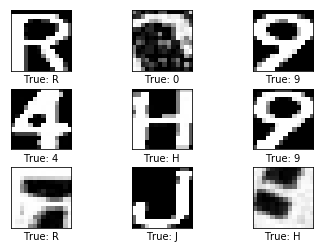

In [4]:
plot_images(data.x_train[:9], data.y_train_cls[:9])

In [5]:
x = tf.placeholder(tf.float32, [None, data.img_size_flat], name='x')
y_true = tf.placeholder(tf.float32, [None, data.num_classes], name='y_true')
y_true_cls = tf.argmax(y_true, axis=1)

In [6]:
new_weights = lambda shape: tf.Variable(tf.truncated_normal(shape, stddev=0.05))
new_biases = lambda length: tf.Variable(tf.constant(0.05, shape=[length]))
    
def new_fc_layer(inp, num_inputs, num_outputs, use_relu=True, keep_prob=0):
    weights = new_weights(shape=[num_inputs, num_outputs])
    biases = new_biases(length=num_outputs)

    layer = inp
    
    if keep_prob:
        layer = tf.nn.dropout(inp, keep_prob) * keep_prob

    layer = tf.matmul(inp, weights) + biases

    if use_relu:
        layer = tf.nn.relu(layer)

    return layer

In [7]:
fc1_size = 128 
fc2_size = 64 

In [8]:
layer_fc2 = new_fc_layer(inp=x, num_inputs=data.img_size_flat, num_outputs=fc2_size, use_relu=True, keep_prob=0.3)
layer_fc2

<tf.Tensor 'Relu:0' shape=(?, 64) dtype=float32>

In [9]:
layer_fc3 = new_fc_layer(inp=layer_fc2, num_inputs=fc2_size, num_outputs=data.num_classes)
layer_fc3

<tf.Tensor 'Relu_1:0' shape=(?, 36) dtype=float32>

In [10]:
y_pred = tf.nn.softmax(layer_fc3)
y_pred_cls = tf.argmax(y_pred, axis=1)

In [11]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=layer_fc3, labels=y_true)
cost = tf.reduce_mean(cross_entropy)

In [12]:
optimizer = tf.train.AdamOptimizer(learning_rate=1e-3).minimize(cost)

In [13]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [14]:
session = tf.Session()
session.run(tf.global_variables_initializer())

In [15]:
train_batch_size = 64

total_iterations = 0

def optimize(num_iterations):
    global total_iterations
    start_time = time.time()

    for i in range(total_iterations, total_iterations + num_iterations):
        x_batch, y_true_batch, y_batch_cls = data.random_batch(batch_size=train_batch_size)

        feed_dict_train = {x: x_batch, y_true: y_true_batch}
        session.run(optimizer, feed_dict=feed_dict_train)

        if i % 100 == 0:
            acc = session.run(accuracy, feed_dict=feed_dict_train)
            msg = "Optimization Iteration: {0:>6}, Training Accuracy: {1:>6.1%}"
            print(msg.format(i + 1, acc))

    total_iterations += num_iterations
    end_time = time.time()
    time_dif = end_time - start_time

    # Print the time-usage.
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))

In [16]:
#print(data.num_train)
optimize(10000)

Optimization Iteration:      1, Training Accuracy:   7.8%
Optimization Iteration:    101, Training Accuracy:  23.4%
Optimization Iteration:    201, Training Accuracy:  21.9%
Optimization Iteration:    301, Training Accuracy:  29.7%
Optimization Iteration:    401, Training Accuracy:  53.1%
Optimization Iteration:    501, Training Accuracy:  50.0%
Optimization Iteration:    601, Training Accuracy:  64.1%
Optimization Iteration:    701, Training Accuracy:  70.3%
Optimization Iteration:    801, Training Accuracy:  68.8%
Optimization Iteration:    901, Training Accuracy:  59.4%
Optimization Iteration:   1001, Training Accuracy:  70.3%
Optimization Iteration:   1101, Training Accuracy:  75.0%
Optimization Iteration:   1201, Training Accuracy:  71.9%
Optimization Iteration:   1301, Training Accuracy:  65.6%
Optimization Iteration:   1401, Training Accuracy:  68.8%
Optimization Iteration:   1501, Training Accuracy:  70.3%
Optimization Iteration:   1601, Training Accuracy:  78.1%
Optimization I

In [17]:
test_batch_size = 256

def print_test_accuracy():
    cls_pred = np.zeros(shape=data.num_test, dtype=np.int)
    i = 0

    while i < data.num_test:
        j = min(i + test_batch_size, data.num_test)
        
        images = data.x_test_flat[i:j, :]
        labels = data.y_test[i:j, :]

        feed_dict = {x: images,
                     y_true: labels}

        cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)

        i = j

    cls_true = data.y_test_cls
    
    correct = cls_true.transpose() == cls_pred
    
    correct_sum = correct.sum()
    acc = float(correct_sum) / data.num_test

    # Print the accuracy.
    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, correct_sum, data.num_test))

In [18]:
print_test_accuracy()

Accuracy on Test-Set: 46.9% (84 / 179)
